In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
from tqdm import tqdm
from IPython import display
import time

# Save results

In [2]:
import os
import pickle 

FILE_PATH = "hill_valley_results.pkl"

def save_dictionary(dict_):
    with open(FILE_PATH, 'wb') as f:
        pickle.dump(dict_, f)

def load_dictionary():
    try:
        with open(FILE_PATH, 'rb') as f:
            loaded_dict = pickle.load(f)
    except:
        loaded_dict = {}
        for Ry in Ry_vals:
            for s in s_vals:
                loaded_dict[f'{Ry},{s}']= []
    return loaded_dict

# Load data

In [3]:
data, meta = arff.loadarff(open("datasets/hill_valley.arff"))

In [4]:
df = pd.DataFrame(data)
df = df.applymap(lambda x: int(x.decode('utf-8')) if isinstance(x, bytes) else x)
print(df.shape)

(1212, 101)


In [5]:
df.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,Class
0,39.02,36.49,38.20,38.85,39.38,39.74,37.02,39.53,38.81,38.79,...,36.62,36.92,38.80,38.52,38.07,36.73,39.46,37.50,39.10,0
1,1.83,1.71,1.77,1.77,1.68,1.78,1.80,1.70,1.75,1.78,...,1.80,1.79,1.77,1.74,1.74,1.80,1.78,1.75,1.69,1
2,68177.69,66138.42,72981.88,74304.33,67549.66,69367.34,69169.41,73268.61,74465.84,72503.37,...,73438.88,71053.35,71112.62,74916.48,72571.58,66348.97,71063.72,67404.27,74920.24,1


# Data Visualisation

### Plot single elements

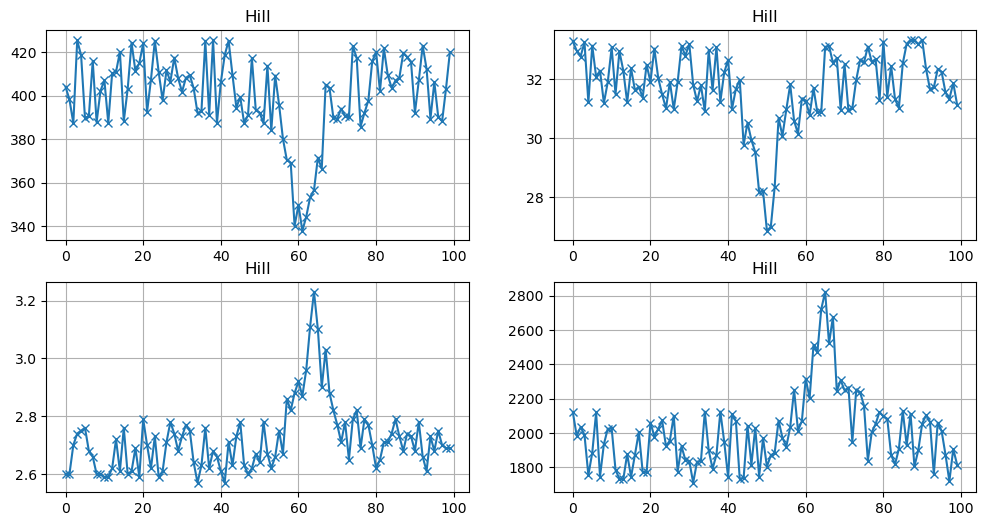

In [6]:
def plot_element(i, ax):
    ax.plot(df.iloc[i][:-1].values, marker='x')
    ax.grid('on')
    ax.set_title('Valley' if df['Class'].iloc[i] == -1 else 'Hill')

idx_valleys = list(df.loc[df['Class'] == 0].index)
idx_hills = list(df.loc[df['Class'] == 1].index)

valleys_to_plot = np.random.choice(idx_valleys, replace=False, size=2)
hills_to_plot = np.random.choice(idx_hills, replace=False, size=2)

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
plot_element(valleys_to_plot[0], axs[0][0])
plot_element(valleys_to_plot[1], axs[0][1])
plot_element(hills_to_plot[0], axs[1][0])
plot_element(hills_to_plot[1], axs[1][1])

### Average of all Hills/Valleys

In [7]:
avg_valleys = df.loc[df['Class'] == 0].drop(columns=['Class']).mean().values
avg_hills = df.loc[df['Class'] == 1].drop(columns=['Class']).mean().values

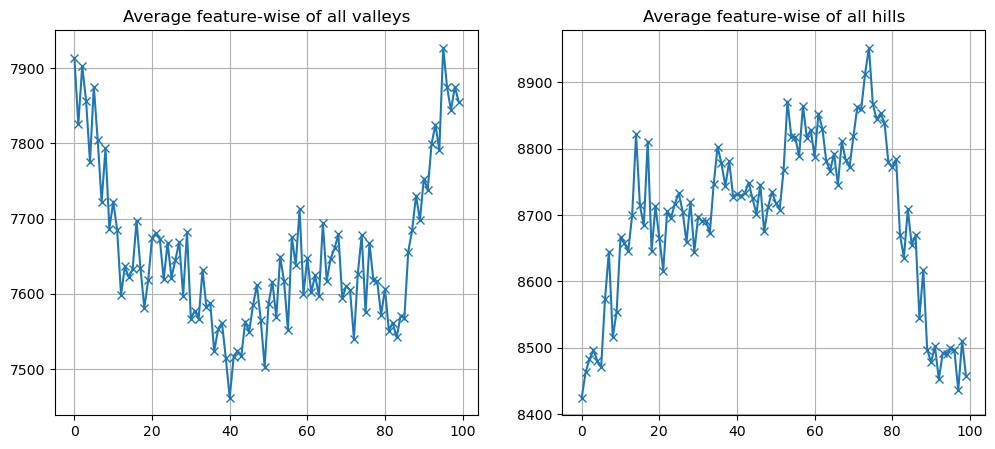

In [8]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
ax0.plot(avg_valleys, marker='x')
ax0.grid('on')
ax0.set_title('Average feature-wise of all valleys')

ax1.plot(avg_hills, marker='x')
ax1.grid('on')
ax1.set_title('Average feature-wise of all hills');

# Preprocessing

### Scale data

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df.drop(columns=['Class']))

In [11]:
df[list(df.columns)[:-1]] = scaled
df.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,Class
0,-0.452487,-0.453618,-0.451009,-0.452502,-0.453430,-0.453874,-0.452309,-0.451419,-0.451509,-0.451673,...,-0.454998,-0.455696,-0.453324,-0.454918,-0.453962,-0.454009,-0.456096,-0.451643,-0.455455,0
1,-0.454557,-0.455564,-0.453024,-0.454564,-0.455543,-0.455992,-0.454263,-0.453516,-0.453571,-0.453742,...,-0.456958,-0.457675,-0.455391,-0.456983,-0.455980,-0.455955,-0.458218,-0.453623,-0.457554,1
2,3.339835,3.244667,3.583381,3.676918,3.330907,3.414915,3.383665,3.607587,3.689084,3.598118,...,3.676649,3.545037,3.514595,3.749207,3.573661,3.240539,3.542787,3.279074,3.746168,1


# Gibbs Sampler

### Import and define function

In [12]:
%run GibbsSampler.ipynb

Nb CPU cores: 12


In [13]:
l = 0
T = len(df)
k = len(df.columns) - 1 # -1 accounts for the fact that we df['Class'] will be Y

In [14]:
a, b, A, B = 1, 1, 1, 1

In [15]:
def draw_initial_parameters(X, Ry, s, a=a, b=b, A=A, B=B, T=T):
    q = draw_initial_q(a=a, b=b)
    r2 = draw_initial_R2(A=A, B=B)
    k = X.shape[1]
    beta, z = draw_initial_beta(s, k=k)
    sigma_squared = draw_inital_sigma_squared(X, beta, Ry, T=T)
    v_x_bar = (1/k) * sum([np.var(x) for x in X])
    gamma2 = compute_gamma2(X, r2, q, v_x_bar, k=k)
    q_grid = np.concatenate((np.arange(0.001, 0.1, 0.001), np.arange(0.1, 0.9, 0.01), np.arange(0.9, 1, 0.001)))
    return q, r2, beta, sigma_squared, z, v_x_bar, gamma2, q_grid

In [16]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def predict_proba(X, beta):
    return sigmoid(X @ beta)
  
def predict(X, beta):
  return np.where(predict_proba(X, beta) > 0.5, 1, 0)
  
def log_loss(Y, X, beta):
  epsilon = 1e-15 
  # Clip probabilities to avoid log(0) or log(1)
  predicted_probs = np.clip(predict_proba(X, beta), epsilon, 1 - epsilon)
  
  loss = -np.mean(Y * np.log(predicted_probs) + (1 - Y) * np.log(1 - predicted_probs))
  return loss

def accuracy(Y, X, beta):
  return np.mean(Y == predict(X, beta))

In [17]:
def weighted_avg_i(X, index, nb_previous_elements):
    lower_index = max(0, index - nb_previous_elements + 1)
    return np.mean(X[lower_index:index+1])

def weighted_avg(X, nb_previous_elements):
    w = np.zeros_like(X)
    for i in range(len(X)):
        w[i] = weighted_avg_i(X, i, nb_previous_elements)
    return w

In [18]:
def gibbs_sampling(q, r2, Y, X, beta, sigma_squared, z, v_x_bar, gamma2, q_grid, k, n_iter, burn_in, T=T, display_=True):
    parameters = {}
    parameters['sigma_squared'] = []
    parameters['r2'] = []
    parameters['q'] = []
    parameters['loss'] = []
    parameters['accuracy'] = []
    
    best_beta = None
    best_loss = np.inf
    
    range_ = tqdm(range(n_iter)) if display_ else range(n_iter)
    for i in range_:
        r2, q = draw_r2(X, z, beta, sigma_squared, v_x_bar, q_grid)
        z = draw_z(Y, X, beta, gamma2, z, q, T=T)
        sigma_squared = draw_sigma(Y, X, beta, gamma2, z)
        beta_tilde = draw_beta_tilde(Y, X, beta, gamma2, z, sigma_squared)

        if i >= burn_in:
            parameters['sigma_squared'].append(sigma_squared)
            parameters['r2'].append(r2)
            parameters['q'].append(q)
        
        # reconstruct beta from drawn beta_tilde and z
        beta = reconstruct_beta(beta_tilde, z, k=k)
        gamma2 = compute_gamma2(X, r2, q, v_x_bar, k=k)
        
        # compute loss and accuracy
        loss = log_loss(Y, X, beta)
        acc = accuracy(Y, X, beta)
        parameters['loss'].append(loss)
        parameters['accuracy'].append(acc)
        
        if loss <= best_loss:
            best_loss = loss
            best_beta = beta
        
    return parameters, beta, best_loss, best_beta

In [19]:
def run_gibbs_sampler(X, Y, Ry, s, n_iter=6000, burn_in=1000, a=a, b=b, A=A, B=B, T=T, display_=True):
    q, r2, beta, sigma_squared, z, v_x_bar, gamma2, q_grid = draw_initial_parameters(X, Ry, s, a=a, b=b, A=A, B=B, T=T)
    params, beta, best_loss, best_beta = gibbs_sampling(q, r2, Y, X, beta, sigma_squared, z, v_x_bar, gamma2, q_grid, k=X.shape[1], n_iter=n_iter, burn_in=burn_in, T=T, display_=display_)
    return params, beta, best_loss, best_beta

### Run Grid Search

In [20]:
X = df.drop(columns=['Class']).values.astype(np.float64)
Y = df['Class'].values.astype(np.float64)

In [21]:
Ry_vals = [round(x, 2) for x in np.linspace(0.02, 0.5, 5)]
s_vals = [5, 10, 25, 50, 100]

In [22]:
def cv_gibbs_sampler(X, Y, Ry, s, counter=-1, cv=3, n_iter=6000, burn_in=1000, a=a, b=b, A=A, B=B, T=T, display_=True):
    best_best_loss = np.inf
    best_params, best_beta, best_best_beta = None, None, None
    
    for i in range(cv):
        if display_:
            print(f'Dataset {counter+1}/{len(Ry_vals)*len(s_vals)} | Ry: {Ry}, s: {s} -> Running cv {i+1}/{cv}')
        params, beta, best_loss, best_beta = run_gibbs_sampler(X, Y, Ry, s, n_iter=n_iter, burn_in=burn_in, a=a, b=b, A=A, B=B, T=T, display_=display_)
        if best_loss <= best_best_loss:
            best_params, best_beta, best_best_loss, best_best_beta = params, beta, best_loss, best_beta
        display.clear_output(wait=False)
        time.sleep(0.2)
    return best_params, best_beta, best_best_loss, best_best_beta

In [23]:
def min_length_key(dic):
    min_ = float('inf')
    for key in dic.keys():
        min_ = min(min_, len(dic[key]))
    return min_

In [24]:
nb_iterations = 1

for iteration in range(nb_iterations):
    counter = 0
    for Ry in Ry_vals:
        for s in s_vals:
            dict_results = load_dictionary()
            if len(dict_results[f'{Ry},{s}']) <= min_length_key(dict_results):
                params, beta, best_loss, best_beta = cv_gibbs_sampler(X, Y, Ry, s, counter=counter, cv=3, n_iter=6000, 
                                                                    burn_in=1000, a=a, b=b, A=A, B=B, T=T, display_=True)
                dict_results[f'{Ry},{s}'].append([params, beta, best_loss, best_beta])
                save_dictionary(dict_results)
            counter += 1

### Run Best Model

In [ ]:
best_avg_acc = 0
best_key = None
for key in dict_results.keys():
    avg_acc = np.mean(dict_results[key][0][0]['accuracy'])
    if avg_acc >= best_avg_acc:
        best_avg_acc = avg_acc
        best_key = key

In [136]:
Ry, s = best_key.split(',')
Ry = float(Ry)
s = int(s)
print(Ry, s)

0.02 5


In [137]:
params, beta, best_loss, best_beta = run_gibbs_sampler(X, Y, Ry, s, n_iter=6000, burn_in=1000, a=a, b=b, A=A, B=B, T=T, display_=True)

100%|██████████| 5000/5000 [07:03<00:00, 11.81it/s]


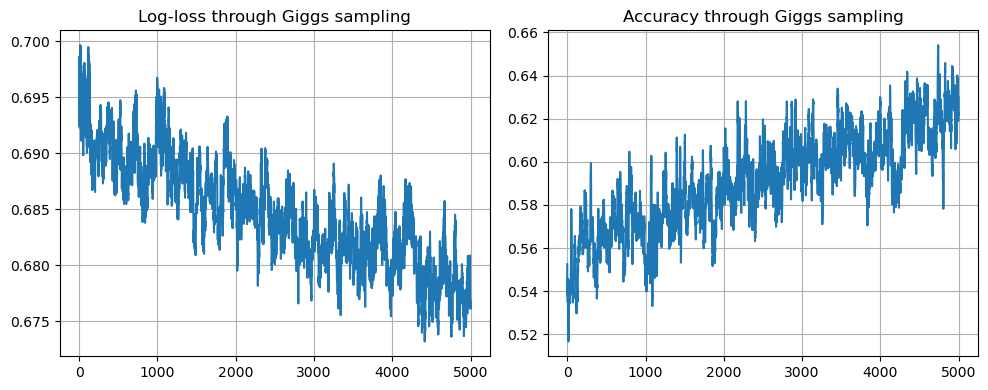

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(params['loss'])
axs[0].grid('on')
axs[0].set_title('Log-loss through Giggs sampling')

axs[1].plot(params['accuracy'])
axs[1].grid('on')
axs[1].set_title('Accuracy through Giggs sampling')

plt.tight_layout()
plt.show()

In [156]:
final_acc = params['accuracy'][-1]
final_loss = params['loss'][-1]

In [159]:
print(f'Final loss = {round(final_loss, 3)}, final_accuracy = {round(100*final_acc, 3)}%')

Final loss = 0.676, final_accuracy = 63.014%
